In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils as ut

from IPython.display import display

In [2]:
bench_all = pd.read_csv('./results/sim/joint_benchmarks.csv', index_col=0)
df = ut.best_h(bench_all)

df['graph_type_d'] = df.apply(lambda x: f"{x['graph_type'].upper()}{x['graph_d']}", axis=1)
df['id'] = df.apply(lambda x: x['id'].upper(), axis=1)

/home/damian/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (24,26,27,28,29,33,34,39,41,42,43,44,45,47,48,57,58,59,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Plots

In [5]:
def select_case(df, n):
    return df.loc[(df['data_n'] == n)]

def select_sem(df, s):
    if s == 'gumbel':
        return df.loc[(df['data_sem'] == s) & (df['id'] != 'anm')]
    else:
        return df.loc[(df['data_sem'] == s)]
    
def select_sem_d(df, s, d):
    if s == 'gumbel':
        return df.loc[(df['data_sem'] == s) & (df['graph_d'] == d) & (df['id'] != 'anm')]
    else:
        return df.loc[(df['data_sem'] == s) & (df['graph_d'] == d)]

def select_sem_gtd(df, s, gtd):
    if s == 'gumbel':
        return df.loc[(df['data_sem'] == s) & (df['graph_type_d'] == gtd) & (df['id'] != 'ANM')]
    else:
        return df.loc[(df['data_sem'] == s) & (df['graph_type_d'] == gtd)]

### sem by gtd

#### with ANM

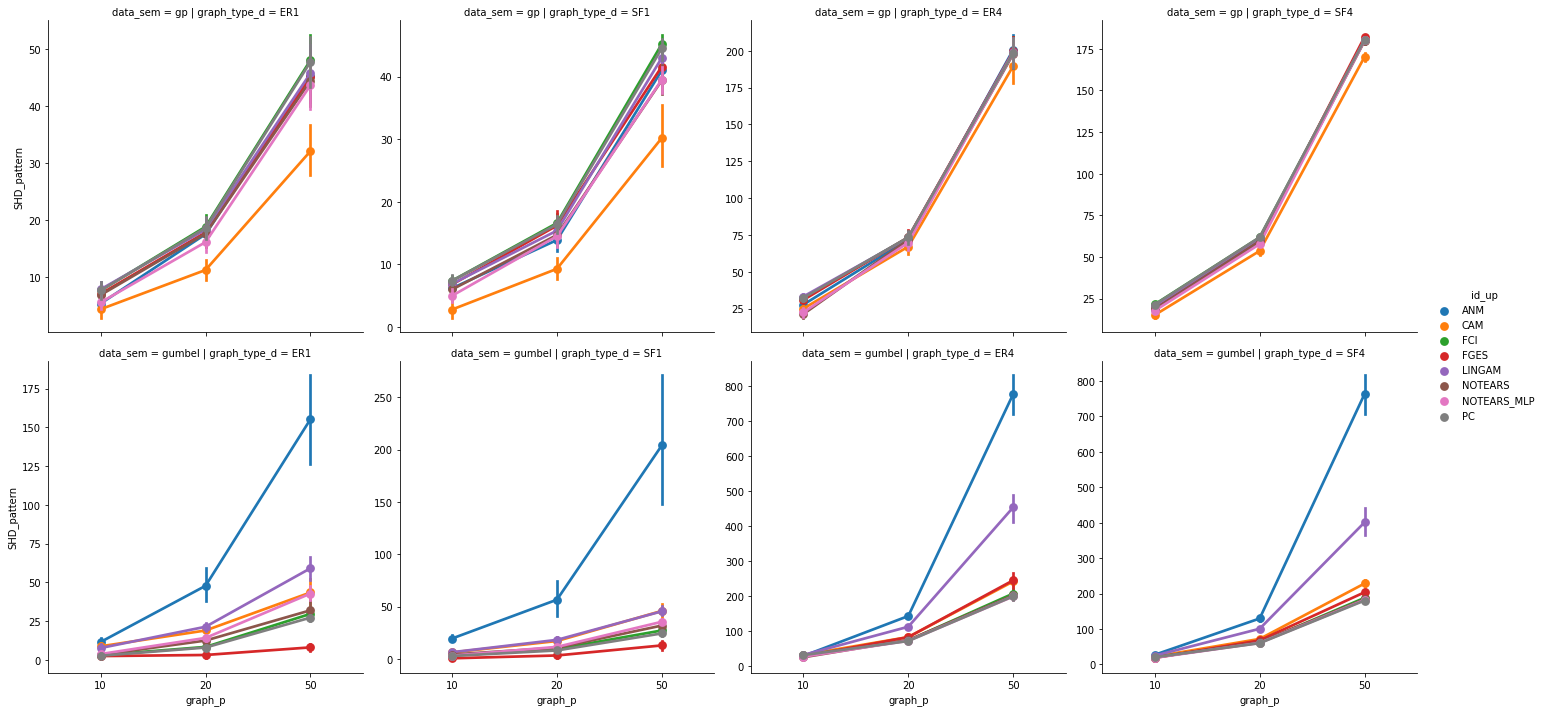

In [4]:
df_selected = select_case(df, 200)
sns.catplot(data=df_selected, x='graph_p', y='SHD_pattern', hue='id_up', col='graph_type_d', row='data_sem', errorbar='se', kind='point', sharey=False)

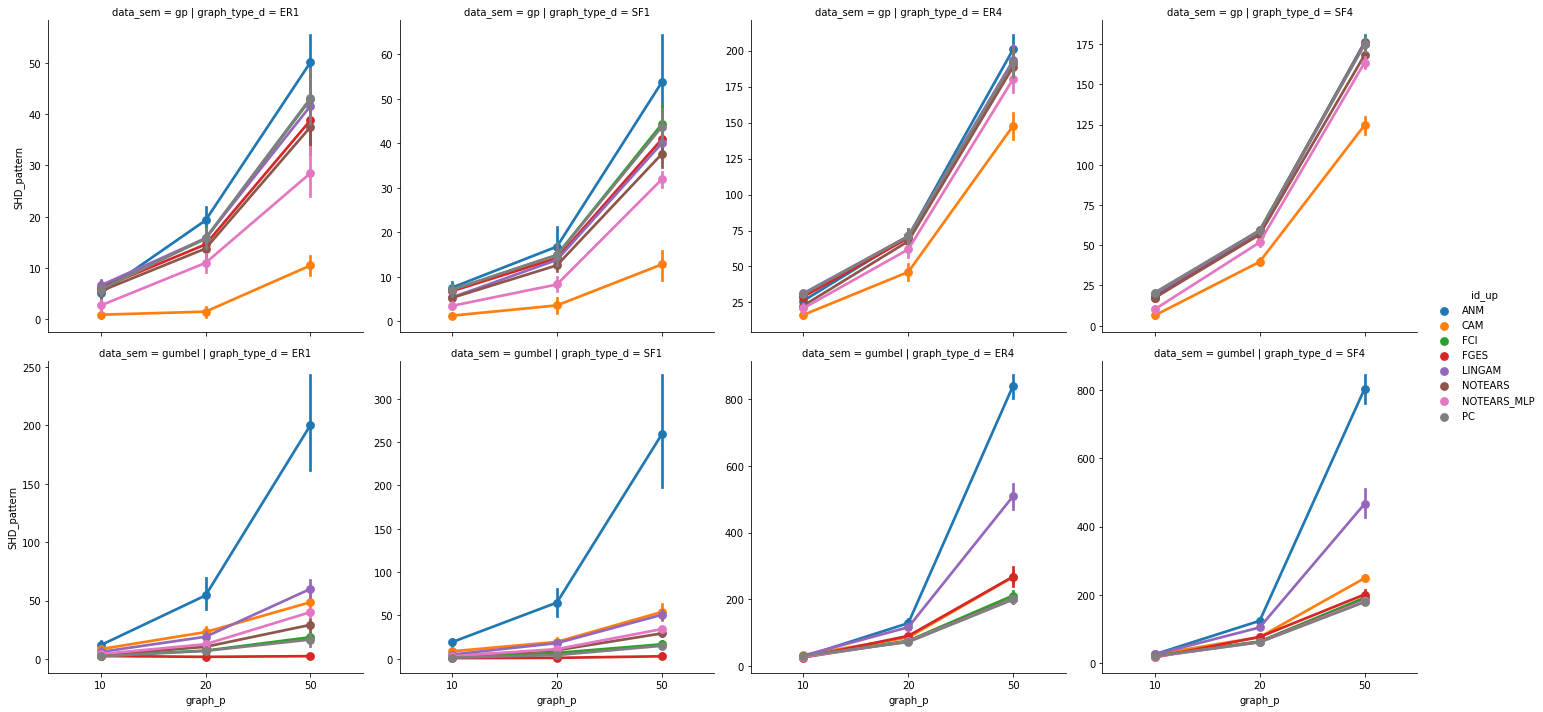

In [5]:
df_selected = select_case(df, 1000)
sns.catplot(data=df_selected, x='graph_p', y='SHD_pattern', hue='id_up', col='graph_type_d', row='data_sem', errorbar='se', kind='point', sharey=False)

#### without ANM

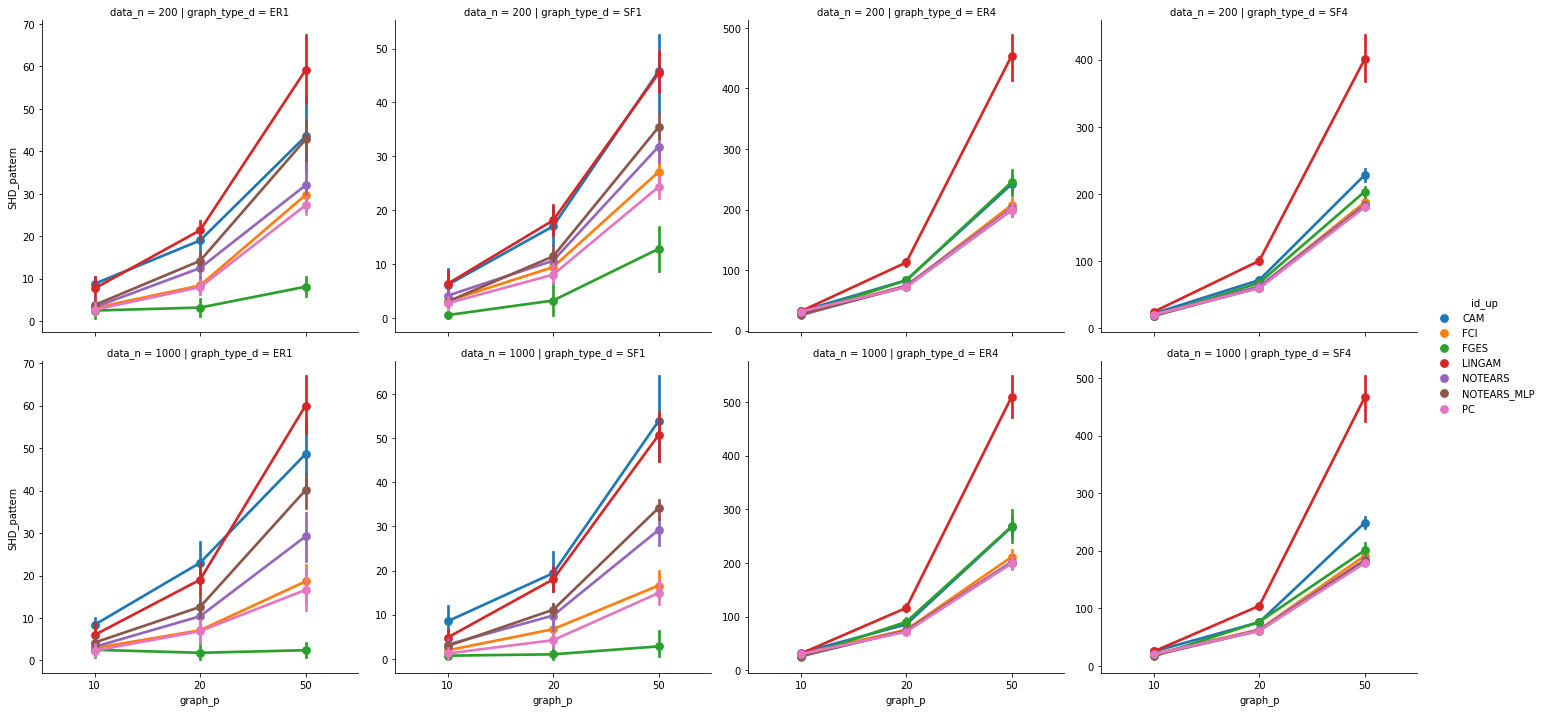

In [6]:
df_selected = select_sem(df, 'gumbel')
sns.catplot(data=df_selected, x='graph_p', y='SHD_pattern', hue='id_up', col='graph_type_d', row='data_n', errorbar='se', kind='point', sharey=False)

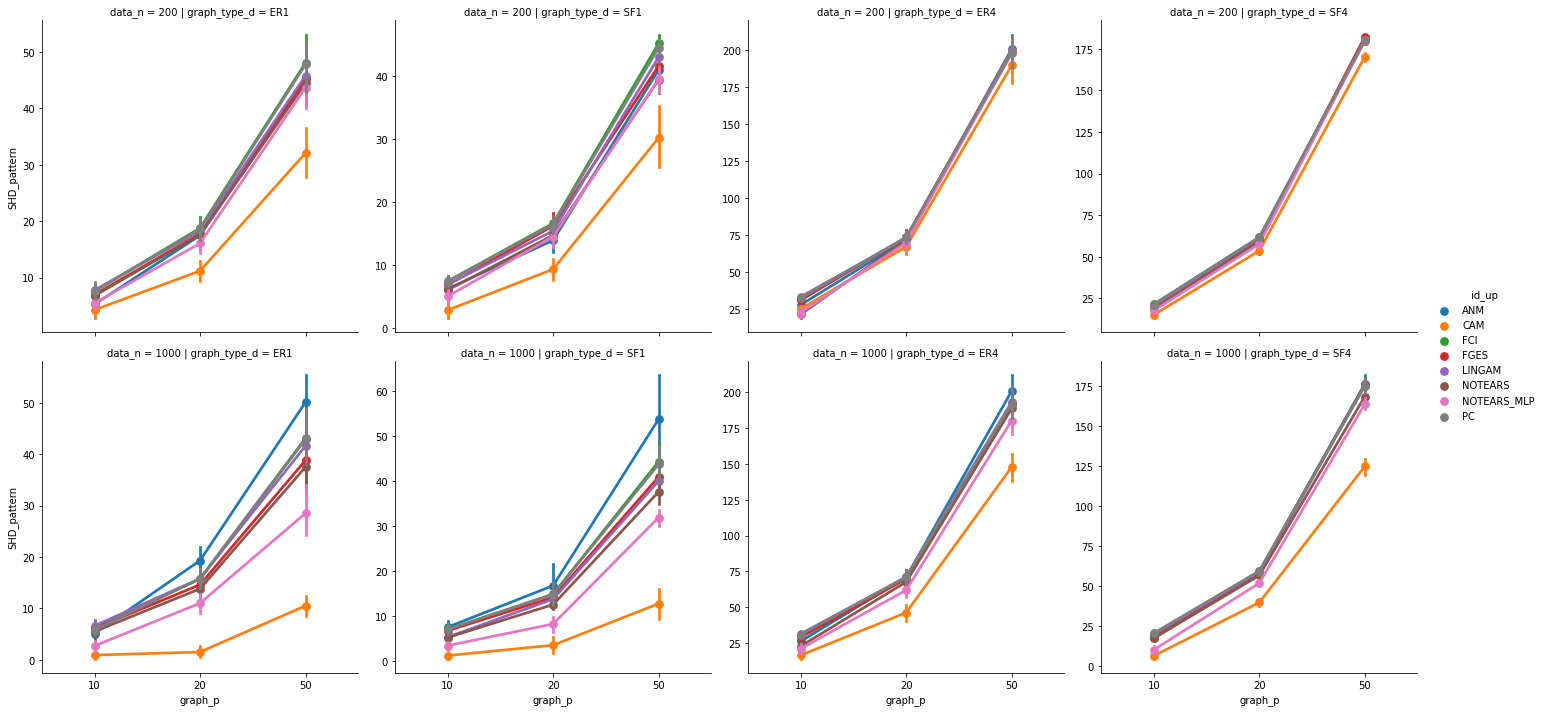

In [7]:
df_selected = select_sem(df, 'gp')
sns.catplot(data=df_selected, x='graph_p', y='SHD_pattern', hue='id_up', col='graph_type_d', row='data_n', errorbar='se', kind='point', sharey=False)

### sem by (gtx, n)

In [8]:
df_plt = df.copy()
df_plt['graph_n'] = df_plt.apply(lambda x: f"{x['graph_type_d']}, n={x['data_n']}", axis=1)

SEM=gumbel, d=1


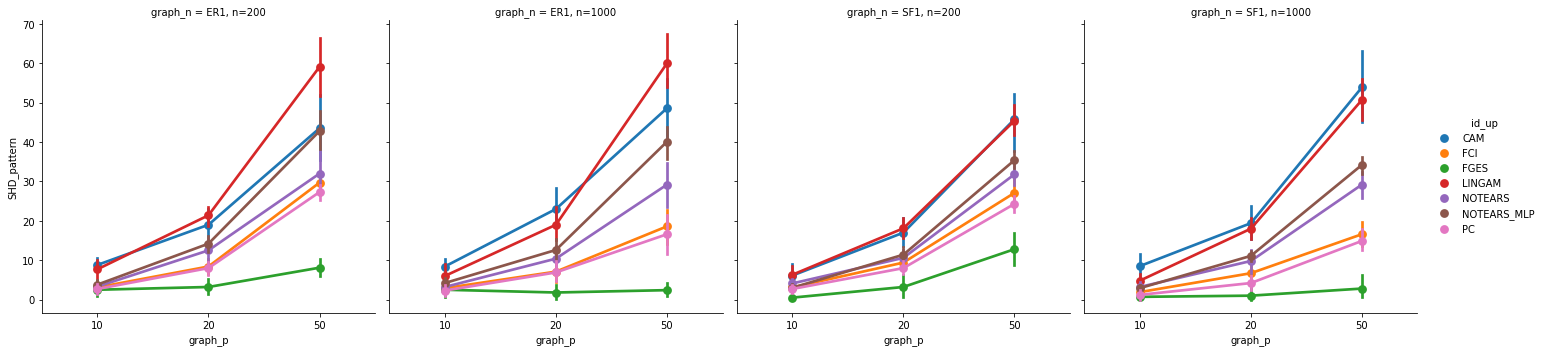

SEM=gumbel, d=4


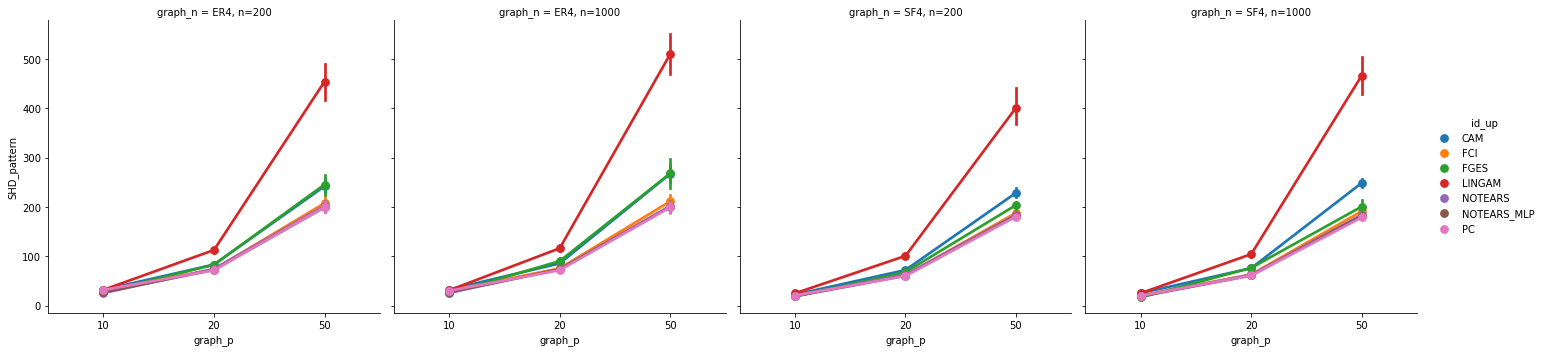

SEM=gp, d=1


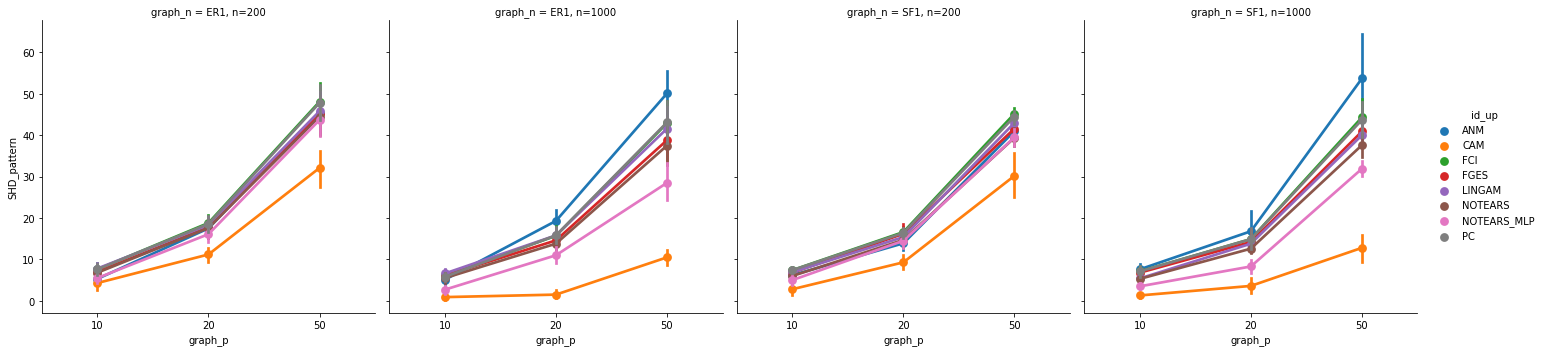

SEM=gp, d=4


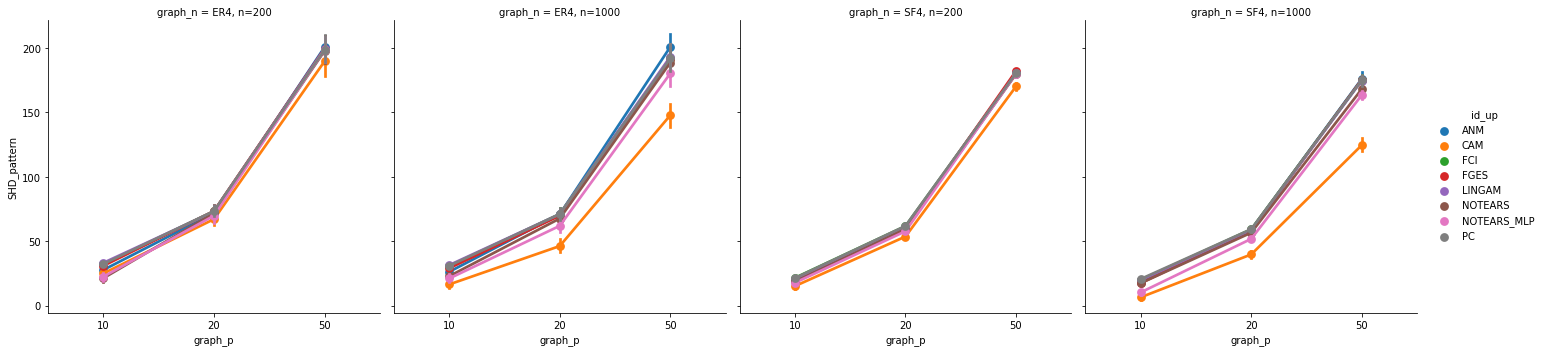

In [9]:
for sem in ['gumbel', 'gp']:
    for d in [1, 4]:
        print(f'SEM={sem}, d={d}')
        df_selected = select_sem_d(df_plt, sem, d)
        sns.catplot(data=df_selected, x='graph_p', y='SHD_pattern', hue='id_up', col='graph_n', errorbar='se', kind='point', sharey=True)
        plt.show()

### (sem, gtd)

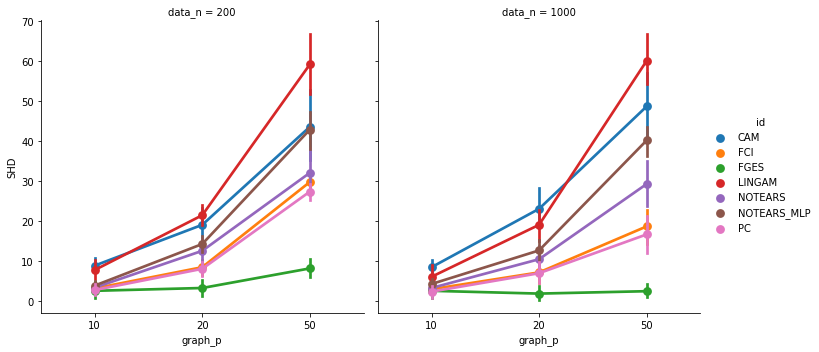

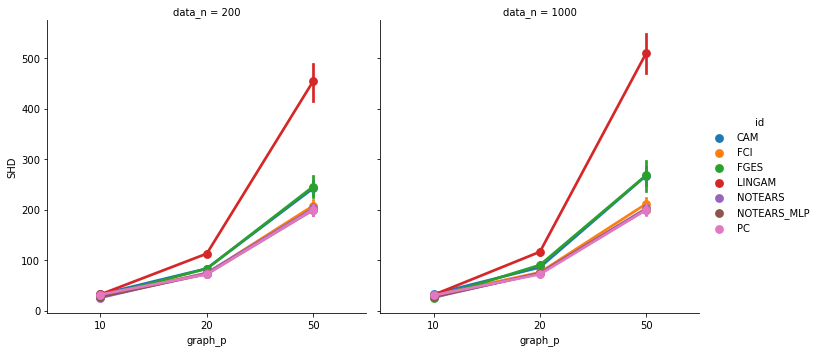

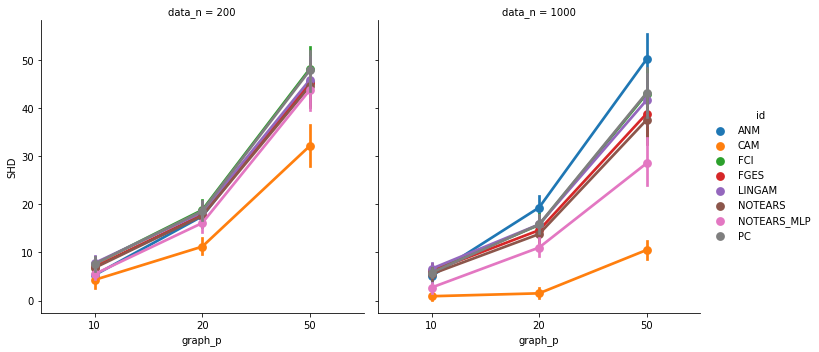

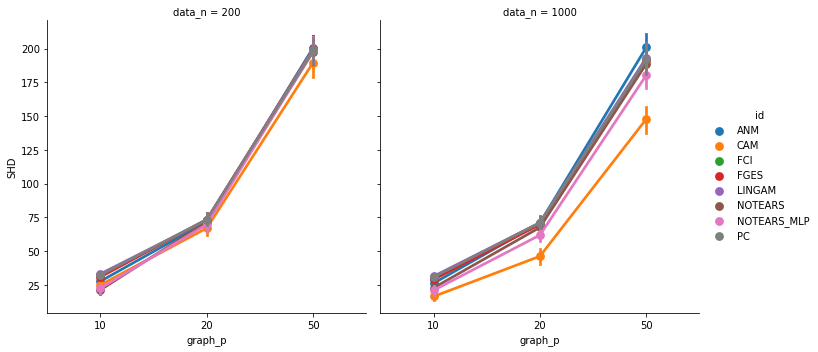

In [10]:
for sem in ['gumbel', 'gp']:
    for gtd in ['ER1', 'ER4']:
        df_selected = select_sem_gtd(df, sem, gtd)
        sns.catplot(data=df_selected, x='graph_p', y='SHD_pattern', hue='id', col='data_n', errorbar='se', kind='point', sharey=True).set(ylabel='SHD')
        #plt.tight_layout()
        plt.savefig(f'./plots/oracle/oracle_{sem}_{gtd}.pdf', dpi=1000)

## Tables -- mean (sem)

In [10]:
df_agg = df.groupby(['id_up', 'graph_p', 'graph_type_d', 'data_sem', 'data_n'], as_index=False).agg(['mean', 'sem'])
df_agg.reset_index(inplace=True)
print()
df_agg['SHD'] = df_agg.apply(lambda x: f"{x['SHD_pattern']['mean']} ({x['SHD_pattern']['sem']:.2f})", axis=1)

In [11]:
def select(df, gtd, p, sem, n):
    return df.loc[(df['graph_type_d'] == gtd) & (df['data_sem'] == sem) & (df['data_n'] == n) & (df['graph_p'] == p), ['id_up', 'SHD']]

def select_complex(df, gt, sem, n):
    gt1 = f'{gt.upper()}1'
    er1 = select(df, gt1, 10, sem, n).merge(select(df, gt1, 20, sem, n), on='id_up').merge(select(df, gt1, 50, sem, n), on='id_up')
    er1.columns = ['id', 'p=10', 'p=20', 'p=50']

    gt4 = f'{gt.upper()}4'
    er4 = select(df, gt4, 10, sem, n).merge(select(df, gt4, 20, sem, n), on='id_up').merge(select(df, gt4, 50, sem, n), on='id_up')
    er4.columns = ['id', 'p=10', 'p=20', 'p=50']

    er = er1.merge(er4, on='id', suffixes=[gt1, gt4])

    er.set_index('id', inplace=True)

    er.columns = pd.MultiIndex.from_tuples([(c[-3:], c[:-3]) for c in er.columns])

    return er

In [12]:
for sem in ['gumbel', 'gp']:
    for gt in ['er', 'sf']:
        for n in [200, 1000]:
            print()
            print('='*30)
            #print(sem, gt, n)
            if sem == 'gumbel':
                print(f"Linear + Gumbel noise, n = {n}")
            else:
                print(f"Nonlinear + Gaussian noise, n = {n}")
            display(select_complex(df_agg, gt, sem, n))
            print()


Linear + Gumbel noise, n = 200


ER1                                      ER4  \
                    p=10         p=20           p=50         p=10   
id                                                                  
ANM          11.6 (1.41)  47.8 (5.87)  155.2 (15.38)  29.1 (2.69)   
CAM           8.8 (0.92)  19.0 (2.04)    43.5 (4.81)  32.0 (1.16)   
FCI           3.1 (0.82)   8.4 (1.11)    29.7 (1.56)  30.8 (0.68)   
FGES          2.5 (1.05)   3.2 (1.06)     8.1 (1.21)  27.6 (1.09)   
LINGAM        7.7 (1.31)  21.4 (1.33)    59.1 (4.20)  31.9 (1.95)   
NOTEARS       3.3 (0.45)  12.5 (1.75)    32.0 (3.22)  25.3 (1.97)   
NOTEARS_MLP   3.8 (0.66)  14.2 (1.09)    42.8 (2.47)  27.1 (1.35)   
PC            2.7 (0.79)   8.0 (0.91)    27.3 (1.09)  31.5 (0.85)   

                                          
                     p=20           p=50  
id                                        
ANM          143.2 (1.72)  777.6 (30.79)  
CAM           83.1 (1.77)   241.9 (7.28)  
FCI           73.5 (2.67)   207.4 (6.47)  
FGES          82.9 (3.27)  245.3 (11.14)  
LINGAM       112.6 (2.84)  453.9 (20.24)  
NOTEARS       74.4 (2.54)   202.1 (4.87)  
NOTEARS_MLP   72.4 (2.67)   199.1 (5.26)  
PC            71.8 (2.91)   199.7 (5.85)



Linear + Gumbel noise, n = 1000


ER1                                      ER4  \
                    p=10         p=20           p=50         p=10   
id                                                                  
ANM          11.8 (1.78)  54.4 (7.62)  200.3 (23.35)  27.5 (2.48)   
CAM           8.4 (0.92)  23.0 (2.56)    48.6 (4.10)  32.5 (0.93)   
FCI           2.9 (0.92)   7.1 (1.67)    18.6 (2.30)  30.2 (0.59)   
FGES          2.5 (1.07)   1.8 (0.90)     2.4 (0.90)  24.9 (1.83)   
LINGAM        6.0 (1.58)  19.0 (2.12)    60.0 (3.65)  31.0 (2.56)   
NOTEARS       3.2 (0.71)  10.4 (1.87)    29.2 (3.04)  25.9 (1.75)   
NOTEARS_MLP   4.2 (0.65)  12.6 (1.42)    40.1 (2.08)  27.2 (1.30)   
PC            2.3 (0.79)   6.9 (1.45)    16.6 (2.66)  30.0 (0.75)   

                                          
                     p=20           p=50  
id                                        
ANM          128.4 (5.82)  841.7 (18.44)  
CAM           85.5 (1.87)   267.3 (9.44)  
FCI           75.5 (2.84)   211.3 (6.74)  
FGES          90.1 (3.61)  268.0 (15.92)  
LINGAM       116.2 (3.58)  509.8 (21.66)  
NOTEARS       74.1 (2.39)   202.1 (4.87)  
NOTEARS_MLP   73.4 (2.29)   199.9 (5.28)  
PC            71.8 (2.53)   199.5 (6.02)



Linear + Gumbel noise, n = 200


SF1                                      SF4  \
                    p=10         p=20           p=50         p=10   
id                                                                  
ANM          19.4 (1.48)  56.5 (9.07)  204.0 (34.59)  27.3 (0.87)   
CAM           6.1 (1.49)  17.0 (1.99)    45.8 (3.94)  22.2 (1.02)   
FCI           3.1 (0.67)   9.4 (0.76)    27.1 (1.87)  20.5 (0.76)   
FGES          0.5 (0.27)   3.2 (1.58)    12.8 (2.28)  18.5 (1.39)   
LINGAM        6.3 (1.26)  18.1 (1.44)    45.4 (2.19)  24.8 (0.96)   
NOTEARS       4.1 (0.60)  10.6 (1.17)    31.8 (1.44)  19.5 (0.73)   
NOTEARS_MLP   3.0 (0.45)  11.4 (1.08)    35.4 (1.21)  18.8 (0.65)   
PC            2.7 (0.56)   8.0 (0.92)    24.3 (1.12)  20.3 (0.62)   

                                          
                     p=20           p=50  
id                                        
ANM          129.7 (3.80)  763.1 (30.32)  
CAM           72.0 (1.74)   228.5 (4.93)  
FCI           61.6 (1.22)   187.9 (1.36)  
FGES          67.8 (1.92)   203.7 (4.04)  
LINGAM       100.7 (2.99)  401.0 (20.20)  
NOTEARS       62.6 (0.40)   184.0 (0.00)  
NOTEARS_MLP   60.6 (0.92)   182.0 (1.15)  
PC            60.1 (1.22)   180.4 (1.56)



Linear + Gumbel noise, n = 1000


SF1                                      SF4  \
                    p=10         p=20           p=50         p=10   
id                                                                  
ANM          19.1 (2.39)  64.8 (8.56)  259.0 (34.85)  25.5 (1.20)   
CAM           8.5 (1.68)  19.4 (2.27)    53.9 (5.16)  25.1 (1.47)   
FCI           1.9 (0.59)   6.7 (1.18)    16.6 (1.77)  20.7 (0.82)   
FGES          0.7 (0.70)   1.0 (0.89)     2.8 (1.72)  16.5 (2.27)   
LINGAM        4.8 (0.90)  18.0 (1.45)    50.7 (2.91)  25.1 (1.88)   
NOTEARS       3.2 (0.71)   9.8 (1.57)    29.2 (1.79)  19.3 (0.72)   
NOTEARS_MLP   2.9 (0.50)  11.1 (0.69)    34.2 (1.15)  18.6 (0.65)   
PC            1.2 (0.63)   4.2 (0.93)    14.9 (1.46)  20.0 (1.06)   

                                          
                     p=20           p=50  
id                                        
ANM          123.6 (4.69)  803.4 (22.65)  
CAM           75.8 (1.01)   248.6 (4.87)  
FCI           63.1 (1.17)   191.2 (2.19)  
FGES          76.4 (3.30)   200.7 (7.84)  
LINGAM       104.2 (2.76)  466.3 (21.49)  
NOTEARS       62.5 (0.43)   184.0 (0.00)  
NOTEARS_MLP   61.0 (0.49)   181.8 (0.73)  
PC            61.0 (1.19)   178.6 (1.40)



Nonlinear + Gaussian noise, n = 200


ER1                                    ER4               \
                   p=10         p=20         p=50         p=10         p=20   
id                                                                            
ANM          5.3 (0.79)  17.5 (1.22)  45.4 (2.07)  27.7 (0.98)  71.8 (2.37)   
CAM          4.3 (1.01)  11.2 (0.92)  32.1 (2.35)  25.0 (1.03)  67.1 (2.66)   
FCI          7.6 (0.76)  18.8 (1.06)  48.1 (2.44)  32.1 (1.00)  73.2 (2.40)   
FGES         7.0 (0.77)  17.8 (1.35)  45.2 (2.37)  30.9 (0.97)  73.4 (2.53)   
LINGAM       7.8 (0.76)  18.3 (1.08)  45.8 (2.57)  33.2 (0.80)  73.0 (2.27)   
NOTEARS      6.8 (0.57)  17.6 (1.08)  44.5 (2.32)  21.3 (1.51)  71.7 (2.18)   
NOTEARS_MLP  5.5 (0.64)  16.1 (1.02)  43.7 (2.20)  22.5 (1.61)  69.8 (2.83)   
PC           7.6 (0.76)  18.6 (1.06)  47.8 (2.31)  32.3 (1.00)  73.4 (2.38)   

                           
                     p=50  
id                         
ANM          200.7 (5.06)  
CAM          189.7 (6.18)  
FCI          198.9 (5.39)  
FGES         199.6 (5.19)  
LINGAM       199.3 (5.10)  
NOTEARS      197.8 (5.17)  
NOTEARS_MLP  198.7 (5.15)  
PC           198.7 (5.42)



Nonlinear + Gaussian noise, n = 1000


ER1                                    ER4               \
                   p=10         p=20         p=50         p=10         p=20   
id                                                                            
ANM          5.1 (0.71)  19.3 (1.32)  50.1 (3.01)  26.2 (1.13)  70.9 (1.56)   
CAM          0.9 (0.38)   1.5 (0.52)  10.5 (1.05)  16.4 (1.28)  46.2 (3.00)   
FCI          6.2 (0.59)  15.7 (1.15)  42.9 (2.75)  30.4 (0.72)  71.1 (2.47)   
FGES         6.1 (0.69)  14.6 (1.24)  38.8 (2.66)  29.0 (0.75)  69.8 (2.89)   
LINGAM       6.6 (0.56)  15.8 (1.09)  41.6 (2.70)  31.4 (0.75)  71.0 (2.36)   
NOTEARS      5.5 (0.65)  13.8 (1.11)  37.5 (2.85)  22.8 (1.57)  67.6 (2.81)   
NOTEARS_MLP  2.7 (0.54)  11.0 (1.02)  28.5 (2.56)  21.0 (1.71)  61.9 (2.86)   
PC           5.8 (0.55)  15.8 (1.06)  43.1 (2.77)  30.8 (0.77)  71.0 (2.49)   

                           
                     p=50  
id                         
ANM          200.9 (5.86)  
CAM          147.8 (5.11)  
FCI          191.9 (5.70)  
FGES         191.5 (6.21)  
LINGAM       193.3 (5.48)  
NOTEARS      188.7 (5.79)  
NOTEARS_MLP  180.3 (5.27)  
PC           192.0 (5.57)



Nonlinear + Gaussian noise, n = 200


SF1                                    SF4               \
                   p=10         p=20         p=50         p=10         p=20   
id                                                                            
ANM          6.2 (0.49)  13.9 (0.92)  41.0 (1.37)  18.7 (0.83)  59.0 (0.68)   
CAM          2.8 (0.77)   9.3 (0.94)  30.2 (2.68)  15.1 (1.11)  53.6 (1.19)   
FCI          7.4 (0.43)  16.6 (0.72)  45.2 (0.92)  21.5 (0.27)  61.7 (0.52)   
FGES         6.8 (0.44)  16.2 (1.15)  41.6 (1.54)  20.0 (0.68)  59.8 (0.66)   
LINGAM       6.9 (0.35)  15.4 (0.62)  43.0 (0.83)  20.5 (0.56)  61.0 (0.39)   
NOTEARS      6.0 (0.58)  14.7 (0.87)  39.4 (1.21)  18.7 (1.13)  59.5 (0.43)   
NOTEARS_MLP  5.0 (0.58)  14.5 (0.91)  39.5 (1.11)  17.7 (0.62)  57.7 (0.75)   
PC           7.4 (0.43)  16.4 (0.70)  44.5 (0.85)  21.3 (0.30)  61.8 (0.47)   

                           
                     p=50  
id                         
ANM          180.6 (1.42)  
CAM          170.2 (1.39)  
FCI          180.4 (0.93)  
FGES         182.2 (0.74)  
LINGAM       180.3 (0.50)  
NOTEARS      179.8 (0.81)  
NOTEARS_MLP  180.2 (0.59)  
PC           180.5 (0.95)



Nonlinear + Gaussian noise, n = 1000


SF1                                    SF4               \
                   p=10         p=20         p=50         p=10         p=20   
id                                                                            
ANM          7.6 (0.72)  16.8 (2.24)  53.7 (5.24)  17.9 (0.77)  58.8 (1.12)   
CAM          1.3 (0.37)   3.6 (0.95)  12.8 (1.82)   6.4 (1.19)  39.7 (1.23)   
FCI          7.1 (0.71)  14.9 (1.18)  44.3 (2.38)  19.9 (0.75)  59.2 (1.10)   
FGES         6.8 (0.53)  14.2 (1.32)  40.9 (1.95)  17.4 (0.79)  58.4 (0.99)   
LINGAM       5.4 (0.67)  13.8 (0.53)  40.0 (1.58)  19.8 (0.61)  58.6 (0.70)   
NOTEARS      5.3 (0.52)  12.6 (0.56)  37.6 (1.47)  17.4 (0.64)  56.6 (0.79)   
NOTEARS_MLP  3.5 (0.43)   8.3 (0.88)  31.9 (0.97)  10.2 (1.22)  51.8 (1.06)   
PC           7.1 (0.71)  14.9 (1.29)  43.7 (2.22)  20.6 (0.91)  59.3 (1.11)   

                           
                     p=50  
id                         
ANM          176.1 (2.92)  
CAM          124.6 (2.68)  
FCI          175.3 (2.32)  
FGES         175.5 (1.48)  
LINGAM       174.8 (1.89)  
NOTEARS      168.2 (2.44)  
NOTEARS_MLP  163.5 (1.86)  
PC           175.1 (2.32)